# Skip-Gram with Negative Sampling, SGNS

# 1. Negative Sampling 

Word2Vec의 출력층에서는 소프트맥스 함수를 지난 단어 집합 크기의 벡터와 실제값인 원-핫 벡터와의 오차를 구하고 이로부터 임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터 값을 업데이트합니다. 만약 단어 집합의 크기가 수만 이상에 달한다면 이 작업은 굉장히 무거운 작업이므로, Word2Vec은 꽤나 학습하기에 무거운 모델이 됩니다.

Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 만약 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지'와 '고양이', '귀여운'과 같은 단어라면, 사실 이 단어들과 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 수많은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적입니다.

네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법입니다. 가령, 현재 집중하고 있는 주변 단어가 '고양이', '귀여운'이라고 해봅시다. 여기에 '돈가스', '컴퓨터', '회의실'과 같은 단어 집합에서 무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져옵니다. 이렇게 하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환합니다. 주변 단어들을 긍정(positive), 랜덤으로 샘플링 된 단어들을 부정(negative)으로 레이블링한다면 이진 분류 문제를 위한 데이터셋이 됩니다. 이는 기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적입니다.

그림을 통해서 이해해봅시다.

# 2. 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

네거티브 샘플링을 사용하는 Skip-gram(Skip-Gram with Negative Sampling, SGNS) 이하 SGNS는 이와는 다른 접근 방식을 취합니다. SGNS는 다음과 같이 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측합니다.

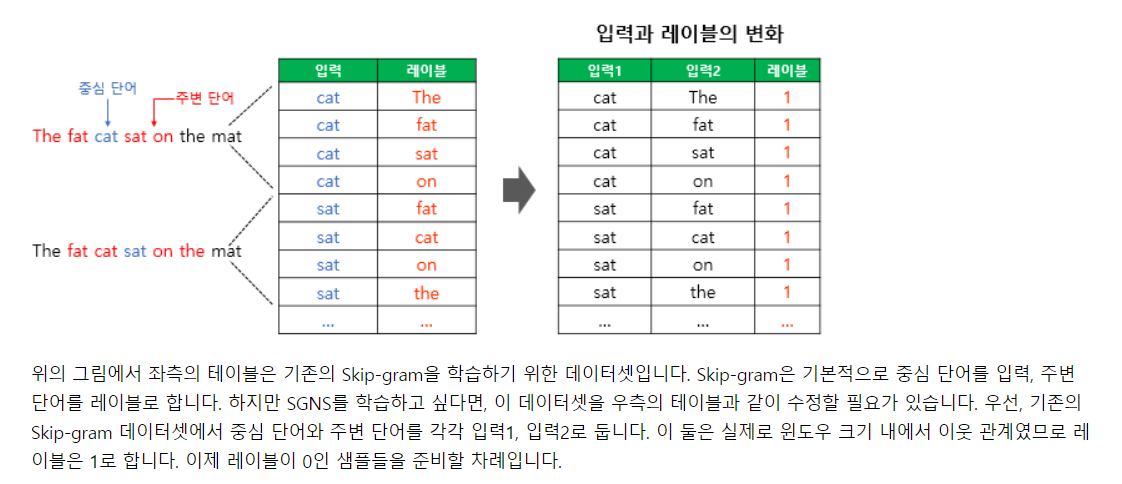

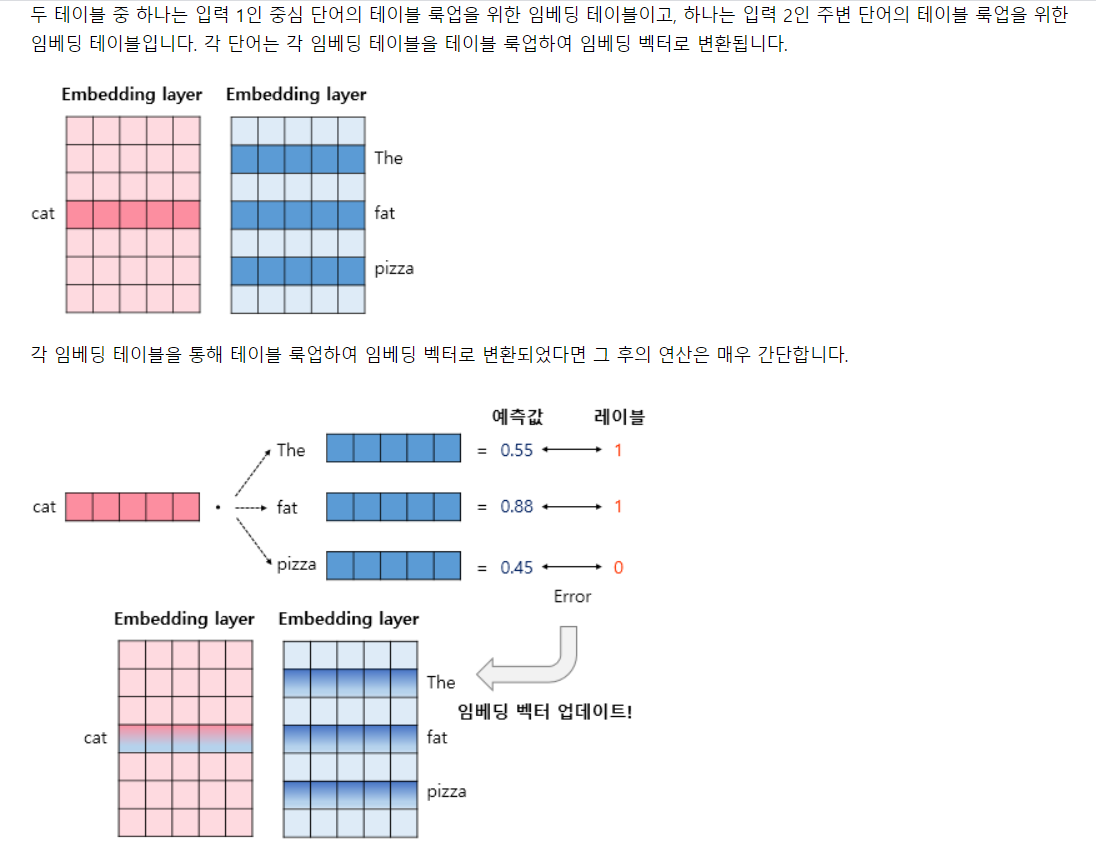

# 3. 20뉴스 그룹 데이터 전처리하기

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset=fetch_20newsgroups(shuffle=True,random_state=1,remove=('headers','footers','quotes')) # 하나의 샘플에 최소 단어 2개가 있어야하므로, 에러 발생 방지 코드
documents=dataset.data
print('총 샘플 수 :',len(documents))


총 샘플 수 : 11314


In [ ]:
documents[:10]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [ ]:
news_df=pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc']=news_df['document'].str.replace("[^a-zA-z]"," ")

# 길이가 3이하인 단어는 제거 ( 길이가 짧은 단어 제거 )
news_df['clean_doc']=news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc']=news_df['clean_doc'].apply(lambda x: x.lower())

In [ ]:
news_df.head()

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...


In [ ]:
news_df.isnull().values.any() # 현재 데이터 프레임에 Null 값이 있는지 확인

False

In [ ]:
news_df.replace("",float("NaN"),inplace=True) # 빈 값(empty) 유무도 확인해야함, 모든 빈 값을 Null 값으로 변환하고 Null 값이 있는지 확인
news_df.isnull().values.any()

True

In [ ]:
news_df.dropna(inplace=True)

In [ ]:
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10997


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# 불용어 제거
stop_words=stopwords.words('english')
tokenized_doc=news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc=tokenized_doc.apply(lambda x:[item for item in x if item not in stop_words])
tokenized_doc=tokenized_doc.to_list()

In [ ]:
tokenized_doc

[['well',
  'sure',
  'story',
  'seem',
  'biased',
  'disagree',
  'statement',
  'media',
  'ruin',
  'israels',
  'reputation',
  'rediculous',
  'media',
  'israeli',
  'media',
  'world',
  'lived',
  'europe',
  'realize',
  'incidences',
  'described',
  'letter',
  'occured',
  'media',
  'whole',
  'seem',
  'ignore',
  'subsidizing',
  'israels',
  'existance',
  'europeans',
  'least',
  'degree',
  'think',
  'might',
  'reason',
  'report',
  'clearly',
  'atrocities',
  'shame',
  'austria',
  'daily',
  'reports',
  'inhuman',
  'acts',
  'commited',
  'israeli',
  'soldiers',
  'blessing',
  'received',
  'government',
  'makes',
  'holocaust',
  'guilt',
  'away',
  'look',
  'jews',
  'treating',
  'races',
  'power',
  'unfortunate'],
 ['yeah',
  'expect',
  'people',
  'read',
  'actually',
  'accept',
  'hard',
  'atheism',
  'need',
  'little',
  'leap',
  'faith',
  'jimmy',
  'logic',
  'runs',
  'steam',
  'sorry',
  'pity',
  'sorry',
  'feelings',
  'denial'

In [ ]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence)<=1]
tokenizied_doc=np.delete(tokenized_doc,drop_train,axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10997


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
tokenizer=Tokenizer() # tensorflow.keras.preprocessing.text https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html
tokenizer.fit_on_texts(tokenized_doc)

word2idx=tokenizer.word_index
idx2word={v:k for k,v in word2idx.items()}
encoded=tokenizer.texts_to_sequences(tokenized_doc)


In [ ]:
tokenizer

In [ ]:
word2idx

{'would': 1,
 'people': 2,
 'like': 3,
 'know': 4,
 'also': 5,
 'think': 6,
 'time': 7,
 'could': 8,
 'well': 9,
 'good': 10,
 'even': 11,
 'first': 12,
 'many': 13,
 'much': 14,
 'make': 15,
 'system': 16,
 'used': 17,
 'right': 18,
 'want': 19,
 'said': 20,
 'file': 21,
 'anyone': 22,
 'need': 23,
 'work': 24,
 'something': 25,
 'problem': 26,
 'since': 27,
 'please': 28,
 'information': 29,
 'back': 30,
 'using': 31,
 'year': 32,
 'really': 33,
 'going': 34,
 'still': 35,
 'program': 36,
 'years': 37,
 'find': 38,
 'believe': 39,
 'must': 40,
 'point': 41,
 'last': 42,
 'available': 43,
 'take': 44,
 'number': 45,
 'space': 46,
 'things': 47,
 'data': 48,
 'government': 49,
 'might': 50,
 'windows': 51,
 'thanks': 52,
 'made': 53,
 'another': 54,
 'mail': 55,
 'without': 56,
 'help': 57,
 'better': 58,
 'sure': 59,
 'read': 60,
 'never': 61,
 'drive': 62,
 'part': 63,
 'case': 64,
 'long': 65,
 'look': 66,
 'however': 67,
 'question': 68,
 'power': 69,
 'world': 70,
 'come': 71,
 'a

In [ ]:
print(encoded[:2])

[[9, 59, 602, 204, 3271, 1489, 474, 698, 9503, 13772, 5521, 15385, 698, 438, 698, 70, 1143, 1092, 1031, 20646, 977, 704, 4276, 698, 216, 204, 1966, 15386, 13772, 4849, 4506, 86, 1526, 6, 50, 148, 584, 658, 4392, 4971, 4850, 1909, 758, 10711, 1104, 7851, 438, 961, 10712, 631, 49, 226, 2659, 4972, 178, 66, 221, 4507, 6059, 69, 4277], [1022, 529, 2, 60, 98, 585, 107, 800, 23, 78, 4508, 331, 8543, 859, 418, 3812, 464, 6484, 464, 2691, 4710, 331, 23, 9, 4711, 7255, 186, 308, 143, 174, 644, 1252, 107, 35151, 14, 978, 35152, 35153, 9504, 11553]]


In [ ]:
vocab_size=len(word2idx)+1

In [ ]:
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 72255


# 4. 네거티브 샘플링을 통한 데이터셋 구성하기

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/skipgrams
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams=[skipgrams(sample,vocabulary_size=vocab_size,window_size=10) for sample in encoded[:10]]
# 10개의 뉴스 그룹 샘플에 대해서 skipgram

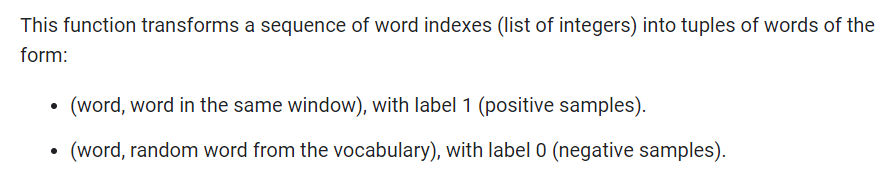

In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs,labels=skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))
    
# 윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록하고, 그렇지 않은 경우는 0의 레이블을 가지도록하여 데이터셋을 구성한다.
# 이 과정은 각각의 뉴스그룹 샘플에 대해서 동일한 프로세스로 수행된다.

(report (584), demoing (36652)) -> 0
(israels (13772), report (584)) -> 1
(inhuman (10711), daily (1909)) -> 1
(daily (1909), soldiers (961)) -> 1
(media (698), media (698)) -> 1


In [ ]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [ ]:
# 첫번째 뉴스 그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [ ]:
skip_grams=[skipgrams(sample,vocabulary_size=vocab_size,window_size=10) for sample in encoded]


# 5. Skip-Gram with Negative Sampling(SGNS) 구현하기

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embed_size=100

In [ ]:
embed_size=100

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻습니다.

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       7225500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       7225500     input_2[0][0]                    
______________________________________________________________________________________________

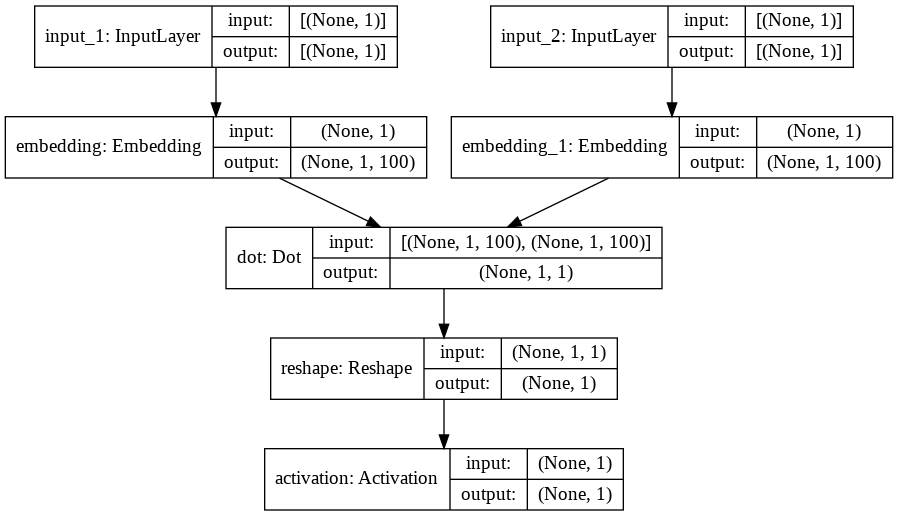

In [ ]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

IndexError: ignored

In [ ]:
import gensim

In [ ]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['soldiers'])